# Notebook to stack multiple scanning 3DXRD layers
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

With this notebook, we stack together multiple scanning 3DXRD layers together in Z.

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# supply the path to one dataset file - we'll find the rest automatically
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'
# common prefix to all dataset names
dset_prefix = "top_"

# are you looking to stack phase-combined layers?
stack_combined = True
# otherwise what is the phase you're interested in stacking?
phase_str = 'Fe'
# are the layers strain refined?
stack_refined = True

# what's the z step in microns?
zstep = None

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"
dset_prefix = "top"
stack_combined = True
stack_refined = True
zstep = 50.0


In [4]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import ImageD11.sinograms.dataset
from ImageD11.sinograms.tensor_map import TensorMap

import ImageD11.nbGui.nb_utils as utils

%matplotlib ipympl

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [7]:
skips_dict = {ds.sample: []}
sample_list = [ds.sample]
samples_dict = utils.find_datasets_to_process(ds.dataroot, skips_dict, dset_prefix, sample_list)

In [8]:
# pick a specific sample to continue

sample = ds.sample
ds_dict = OrderedDict()

for dataset in samples_dict[sample]:
    # read the ds
    dset_path = os.path.join(ds.analysisroot, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
    ds = ImageD11.sinograms.dataset.load(dset_path)
    
    # read the tensormaps
    # choose where to import your TensorMaps from
    
    if stack_combined and stack_refined:
        ds.tensor_map = TensorMap.from_h5(os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refined_tmap_combined.h5'))
    elif stack_combined:
        ds.tensor_map = TensorMap.from_h5(os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap_combined.h5'))
    elif stack_refined:
        ds.tensor_map = TensorMap.from_h5(os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refiend_tmap_{phase_str}.h5'))
    else:
        ds.tensor_map = TensorMap.from_h5(os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap_{phase_str}.h5'))

    ds_dict[dataset] = ds

In [9]:
# in this case, first scan has the Z motor at its lowest value
# you should double-check this for your data!
# this means we're scanning the highest region on the sample first
# then moving down in the sample as we increase the Z number
# therefore we want the combined tensormaps in reverse order

# choose the z step for your data
# in our case we assume it's the same as the y step
# this may not be true for you!!!

if zstep is None:
    zstep = ds.ystep

combined_tensormap = TensorMap.from_stack([ds.tensor_map for ds in list(ds_dict.values())][::-1], zstep=zstep)

# note: if a labels array makes it into the combined tensormap, it is not modified during the stacking procedure!
# labels are original to their own layer

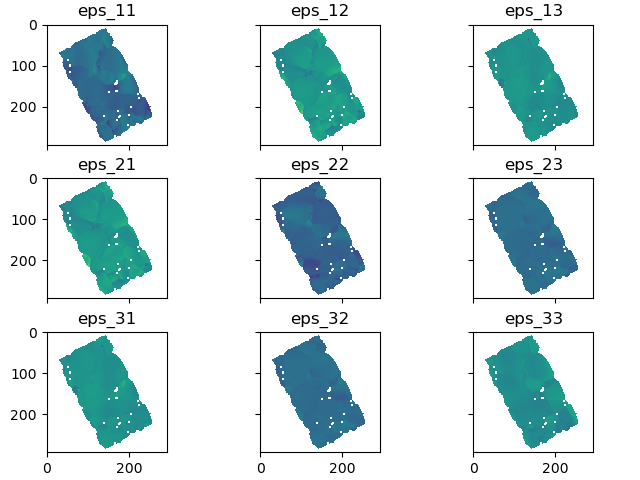

In [10]:
# compute and plot strains for Z slice 0

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, layout='constrained')
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(combined_tensormap.eps_sample[0, ..., i, j])
        axs[i,j].set_title(f'eps_{i+1}{j+1}')
plt.show()

In [11]:
# export to file

output_path = os.path.join(ds.analysisroot, f'{ds.sample}_stacked.h5')

combined_tensormap.to_h5(output_path)
combined_tensormap.to_paraview(output_path)